In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math
import statistics
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO
from datetime import timedelta
from scipy.stats.stats import pearsonr   
import pprint

In [2]:
current_date = datetime.today()
start_date = current_date + relativedelta(months=-6)

## Vol Param

In [3]:
def get_historical_collection_floor(collection_address, start_date, limit=None):
  start_date_unix = time.mktime(start_date.timetuple())
  if limit is not None :
    url = f"https://api.reservoir.tools/events/collections/floor-ask/v1?collection={collection_address}&startTimestamp={start_date_unix}&sortDirection=desc&limit={limit}"
  else:
    url = f"https://api.reservoir.tools/events/collections/floor-ask/v1?collection={collection_address}&startTimestamp={start_date_unix}&sortDirection=desc"
  headers = {
      "Accept": "*/*",
      "x-api-key": "demo-api-key"
  }
  response = requests.get(url, headers=headers)
  out = response.json()
  return out

In [4]:
# convert datetime to unix

bored_ape_address = "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d"
out = get_historical_collection_floor(bored_ape_address, start_date = start_date, limit = 1000)

# Note: Limit must be less than 1000!

In [5]:
floor_asks = []
for event in out['events']:
  collection_ = event['event']
  floorask_ = event['floorAsk']
  floor_asks.append({'price': floorask_['price'],
                     'previousPrice': collection_['previousPrice'],
                     'source': floorask_['source'],
                     'tokenId': floorask_['tokenId'],
                     'createdAt': collection_['createdAt'],
                     'validUntil': floorask_['validUntil']})

floor_asks_df = pd.DataFrame(floor_asks)
floor_asks_df['validUntil'] = pd.to_datetime(floor_asks_df['validUntil'].astype(int), unit = 's')
floor_asks_df['createdAt'] = pd.to_datetime(floor_asks_df['createdAt'])
floor_asks_df = floor_asks_df.sort_values(by = 'createdAt', ascending = False)

In [6]:
floor_asks_df

,price,previousPrice,source,tokenId,createdAt,validUntil
0,87.00,87.17,X2Y2,4146,2022-06-25 19:05:11.253000+00:00,2022-07-21 00:23:08
1,87.17,86.79,X2Y2,7369,2022-06-24 03:43:23.761000+00:00,2022-06-29 19:01:05
2,86.79,87.17,OpenSea,9794,2022-06-24 03:17:06.315000+00:00,2022-06-24 22:38:12
3,87.17,86.70,X2Y2,7369,2022-06-23 12:39:46.993000+00:00,2022-06-29 19:01:05
4,86.70,87.17,OpenSea,766,2022-06-23 10:37:09.560000+00:00,2022-06-26 10:35:56
...,...,...,...,...,...,...
832,109.49,112.00,LooksRare,5171,2022-04-19 05:51:42.756000+00:00,2022-05-19 04:35:59
833,112.00,109.50,OpenSea,2769,2022-04-19 05:51:34.941000+00:00,2022-04-19 21:48:00
834,109.50,109.00,OpenSea,5171,2022-04-19 04:34:20.961000+00:00,2022-04-28 11:57:00
835,109.00,108.00,LooksRare,4751,2022-04-19 02:53:44.772000+00:00,2022-05-17 23:20:00


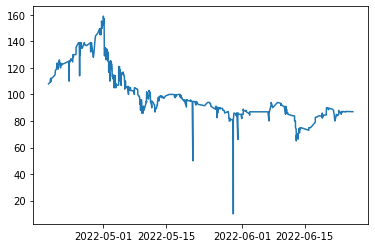

In [7]:
plt.plot(floor_asks_df['createdAt'], floor_asks_df['price'])

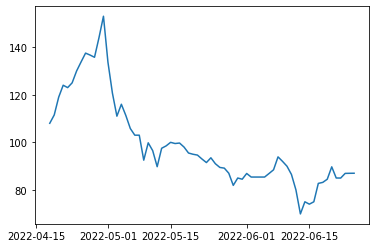

In [8]:
a = floor_asks_df.set_index('createdAt')['price']
floor_asks_daily = a.resample('D').median().ffill()
plt.plot(floor_asks_daily)

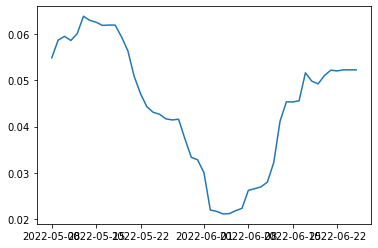

In [9]:
rolling_vol_window = 20
rolling_vol = floor_asks_daily.pct_change().rolling(rolling_vol_window).std()
plt.plot(rolling_vol)

In [10]:
current_vol = rolling_vol[-1]

In [11]:
rolling_vol_array = np.array(rolling_vol)
rolling_vol_array = rolling_vol_array[np.logical_not(np.isnan(rolling_vol_array))]
rolling_vol_array

array([0.05487341, 0.05867432, 0.05950076, 0.05860526, 0.06006468,
       0.06384147, 0.06294999, 0.06254042, 0.06185781, 0.06193974,
       0.06192163, 0.05937132, 0.05635064, 0.05082161, 0.04708763,
       0.04427785, 0.04308043, 0.0426611 , 0.04166946, 0.04143695,
       0.04159103, 0.0373277 , 0.03336935, 0.03282086, 0.03001726,
       0.02197776, 0.02168707, 0.02113576, 0.02119813, 0.02183546,
       0.02234651, 0.02623335, 0.02657792, 0.02698918, 0.02801158,
       0.03221251, 0.04119403, 0.04534482, 0.04531511, 0.04557044,
       0.05161844, 0.04982517, 0.04923654, 0.05102956, 0.05219243,
       0.05203121, 0.05226172, 0.05226069, 0.0522602 ])

In [12]:
mean_vol = statistics.mean(rolling_vol_array)

In [13]:
vol_param = math.sqrt(current_vol/mean_vol)
vol_param

1.0840645471309265

## Crypto Market Req Return

In [14]:
def crypto_timeseries(token, start, finish, interval):
    base_url = 'https://data.messari.io/api/v1/assets/'
    endpoint = f'{token}/metrics/price/time-series?start={start}&end={finish}&interval={interval}'
    url = base_url + endpoint
    result = requests.get(url).json()
    data = result["data"]
    return(data)

nfti_df = crypto_timeseries('NFTI', '2022-06-01', '2022-06-26', '1d')
tcap_df = crypto_timeseries('TCAP', '2022-06-01', '2022-06-26', '1d')
nfti_df
# https://data.messari.io/api/v1/assets/zcash/metrics/price/time-series?start=2020-01-01&end=2020-02-01&interval=1d

{'id': '3b5f9552-e78e-4173-95af-ef555363db44',
 'serial_id': 13297,
 'symbol': 'NFTI',
 'name': 'NFT Index',
 'slug': 'nft-index',
 'contract_addresses': [{'platform': 'ethereum',
   'contract_address': '0xe5feeac09d36b18b3fa757e5cf3f8da6b8e27f4c'}],
 '_internal_temp_agora_id': '',
 'parameters': {'asset_key': 'NFTI',
  'asset_id': '3b5f9552-e78e-4173-95af-ef555363db44',
  'start': '2022-06-01T00:00:00Z',
  'end': '2022-06-26T00:00:00Z',
  'interval': '1d',
  'order': 'ascending',
  'format': 'json',
  'timestamp_format': 'unix-milliseconds',
  'columns': ['timestamp', 'open', 'high', 'low', 'close', 'volume']},
 'schema': {'metric_id': 'price',
  'name': 'Price',
  'description': 'Volume weighted average price computed using Messari Methodology',
  'values_schema': {'timestamp': 'Timestamp in milliseconds since the epoch (1 January 1970 00:00:00 UTC)',
   'open': 'The price of the asset at the beginning of the specified interval in US dollars.',
   'high': 'The highest price of the as

In [15]:
nfti_list = []
for i in range(len(nfti_df['values'])):
    nfti_list.append(nfti_df['values'][i][4])
    
tcap_list = []
for i in range(len(tcap_df['values'])):
    tcap_list.append(tcap_df['values'][i][4])

In [16]:
var_cov_matrix = np.cov(nfti_list, tcap_list)
var_cov_matrix

array([[8748.10111052, 1246.25289006],
       [1246.25289006,  239.26996042]])

In [17]:
beta = var_cov_matrix[0][1]/var_cov_matrix[1][1]

In [18]:
rf = 0.0411
rm = 0.0567

In [19]:
req_r = rf + beta*(rm - rf)
req_r

0.12235359761301895

## OpenSea whitelisted addresses

In [20]:
def nft_whitelist_verification(contract_addy, token_id):
    API_KEY = 'ckey_03e969207241447bb814df6b463'
    headers = {"X-API-KEY": "786f40019b704c9da6c95dc29540db71"}
    base_url = 'https://api.opensea.io/api/v1/asset/'
    endpoint = f'{contract_addy}/{token_id}/?include_orders=false'
    url = base_url + endpoint
    result = requests.get(url, headers = headers).json()
    return(result['collection']['safelist_request_status'])

In [21]:
nft_whitelist_verification('0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb', '11')

'verified'